In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import expectation_reflection as ER
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1)

In [3]:
# load data
#df = np.loadtxt('../1625_data.txt',delimiter=',',dtype=np.str)
df = np.loadtxt('../746_data.txt',delimiter=',',dtype=np.str)

In [4]:
y = df[:,1].astype(float)
np.unique(y,return_counts=True)

(array([-1.,  1.]), array([344, 402]))

In [5]:
x = df[:,0]

In [6]:
x1 = np.array([list(x[t]) for t in range(len(x))])

In [7]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
X = onehot_encoder.fit_transform(x1)

In [8]:
X.shape

(746, 160)

In [9]:
from sklearn.utils import shuffle
X, y = shuffle(X, y)

from sklearn.preprocessing import MinMaxScaler
X = MinMaxScaler().fit_transform(X)

In [10]:
def inference(X_train,y_train,X_test,y_test,method='expectation_reflection'):
    if method == 'expectation_reflection':
        h0,w = ER.fit(X_train,y_train,niter_max=20,regu=0.005)
        y_pred = ER.predict(X_test,h0,w)

    else:
        if method == 'logistic_regression':
            model = LogisticRegression(solver='liblinear')

        if method == 'naive_bayes': 
            model = GaussianNB()

        if method == 'random_forest':
            model = RandomForestClassifier(criterion = "gini", random_state = 1,
                           max_depth=3, min_samples_leaf=5,n_estimators=100)   
            
        if method == 'decision_tree':
            model = DecisionTreeClassifier()  

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test,y_pred)                
                  
    return accuracy

In [11]:
def compare_inference(X,y,train_size):
    npred = 100
    accuracy = np.zeros((len(list_methods),npred))
    precision = np.zeros((len(list_methods),npred))
    recall = np.zeros((len(list_methods),npred))
    accuracy_train = np.zeros((len(list_methods),npred))
    for ipred in range(npred):
        #X, y = shuffle(X, y)
        X_train0,X_test,y_train0,y_test = train_test_split(X,y,test_size=0.2,random_state = ipred)
        idx_train = np.random.choice(len(y_train0),size=int(train_size*len(y)),replace=False)
        X_train,y_train = X_train0[idx_train],y_train0[idx_train]

        for i,method in enumerate(list_methods):
            accuracy[i,ipred] = inference(X_train,y_train,X_test,y_test,method)
            
    return accuracy.mean(axis=1),accuracy.std(axis=1)

In [12]:
list_train_size = [0.8,0.6,0.4,0.2]
list_methods=['logistic_regression','naive_bayes','random_forest','decision_tree','expectation_reflection']
acc = np.zeros((len(list_train_size),len(list_methods)))
acc_std = np.zeros((len(list_train_size),len(list_methods)))
for i,train_size in enumerate(list_train_size):
    acc[i,:],acc_std[i,:] = compare_inference(X,y,train_size)
    print(train_size,acc[i,:])

0.8 [0.9356     0.84246667 0.86253333 0.857      0.9364    ]
0.6 [0.92886667 0.82793333 0.86133333 0.847      0.93026667]
0.4 [0.9146     0.82313333 0.84226667 0.8358     0.91486667]
0.2 [0.88953333 0.81746667 0.81006667 0.8142     0.89226667]


In [13]:
df = pd.DataFrame(acc,columns = list_methods)
df.insert(0, "train_size",list_train_size, True)
df

,train_size,logistic_regression,naive_bayes,random_forest,decision_tree,expectation_reflection
0,0.8,0.935600,0.842467,0.862533,0.8570,0.936400
1,0.6,0.928867,0.827933,0.861333,0.8470,0.930267
2,0.4,0.914600,0.823133,0.842267,0.8358,0.914867
3,0.2,0.889533,0.817467,0.810067,0.8142,0.892267


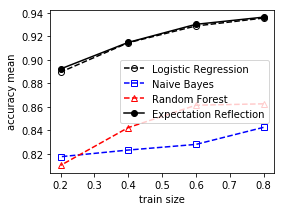

In [14]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc[:,4],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy mean')
plt.legend()

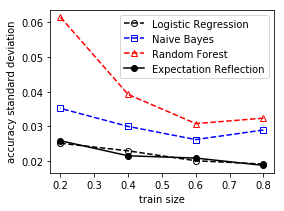

In [15]:
plt.figure(figsize=(4,3))    
plt.plot(list_train_size,acc_std[:,0],'k--',marker='o',mfc='none',label='Logistic Regression')
plt.plot(list_train_size,acc_std[:,1],'b--',marker='s',mfc='none',label='Naive Bayes')
plt.plot(list_train_size,acc_std[:,2],'r--',marker='^',mfc='none',label='Random Forest')
plt.plot(list_train_size,acc_std[:,4],'k-',marker='o',label='Expectation Reflection')
plt.xlabel('train size')
plt.ylabel('accuracy standard deviation')
plt.legend()